[kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/)

# Метрика

В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

In [1]:
from sklearn.metrics import roc_auc_score

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Загрузка данных

1) Посмотрим на случайные строчки. 

2) Посмотрим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() и, если нужно, замените их на что-то.

In [3]:
data = pd.read_csv('./train.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [4]:
#Посмотрим на случайные строчки.
data.sample(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
450,38,89.10,3342,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,One year,Yes,Mailed check,0
643,2,85.65,181.5,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,1
2811,19,100.00,1888.65,Male,0,Yes,Yes,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,One year,No,Bank transfer (automatic),1


In [5]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
#Информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
#Посмотрим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna()
np.where(pd.to_numeric(data['TotalSpent'], errors='coerce').isna())

(array([1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598], dtype=int64),)

In [8]:
#Меняем 'TotalSpent' на численные значения 'IsSeniorCitizen', наоборот, переводим в строку
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
data.loc[:, 'IsSeniorCitizen'] = data.IsSeniorCitizen.astype('str')
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

## Анализ данных

1) Для численных признаков построим гистограмму (*plt.hist(...)*). Для категориальных посчитаем количество каждого значения для каждого признака.

2) Посмотрим на распределение целевой переменной.

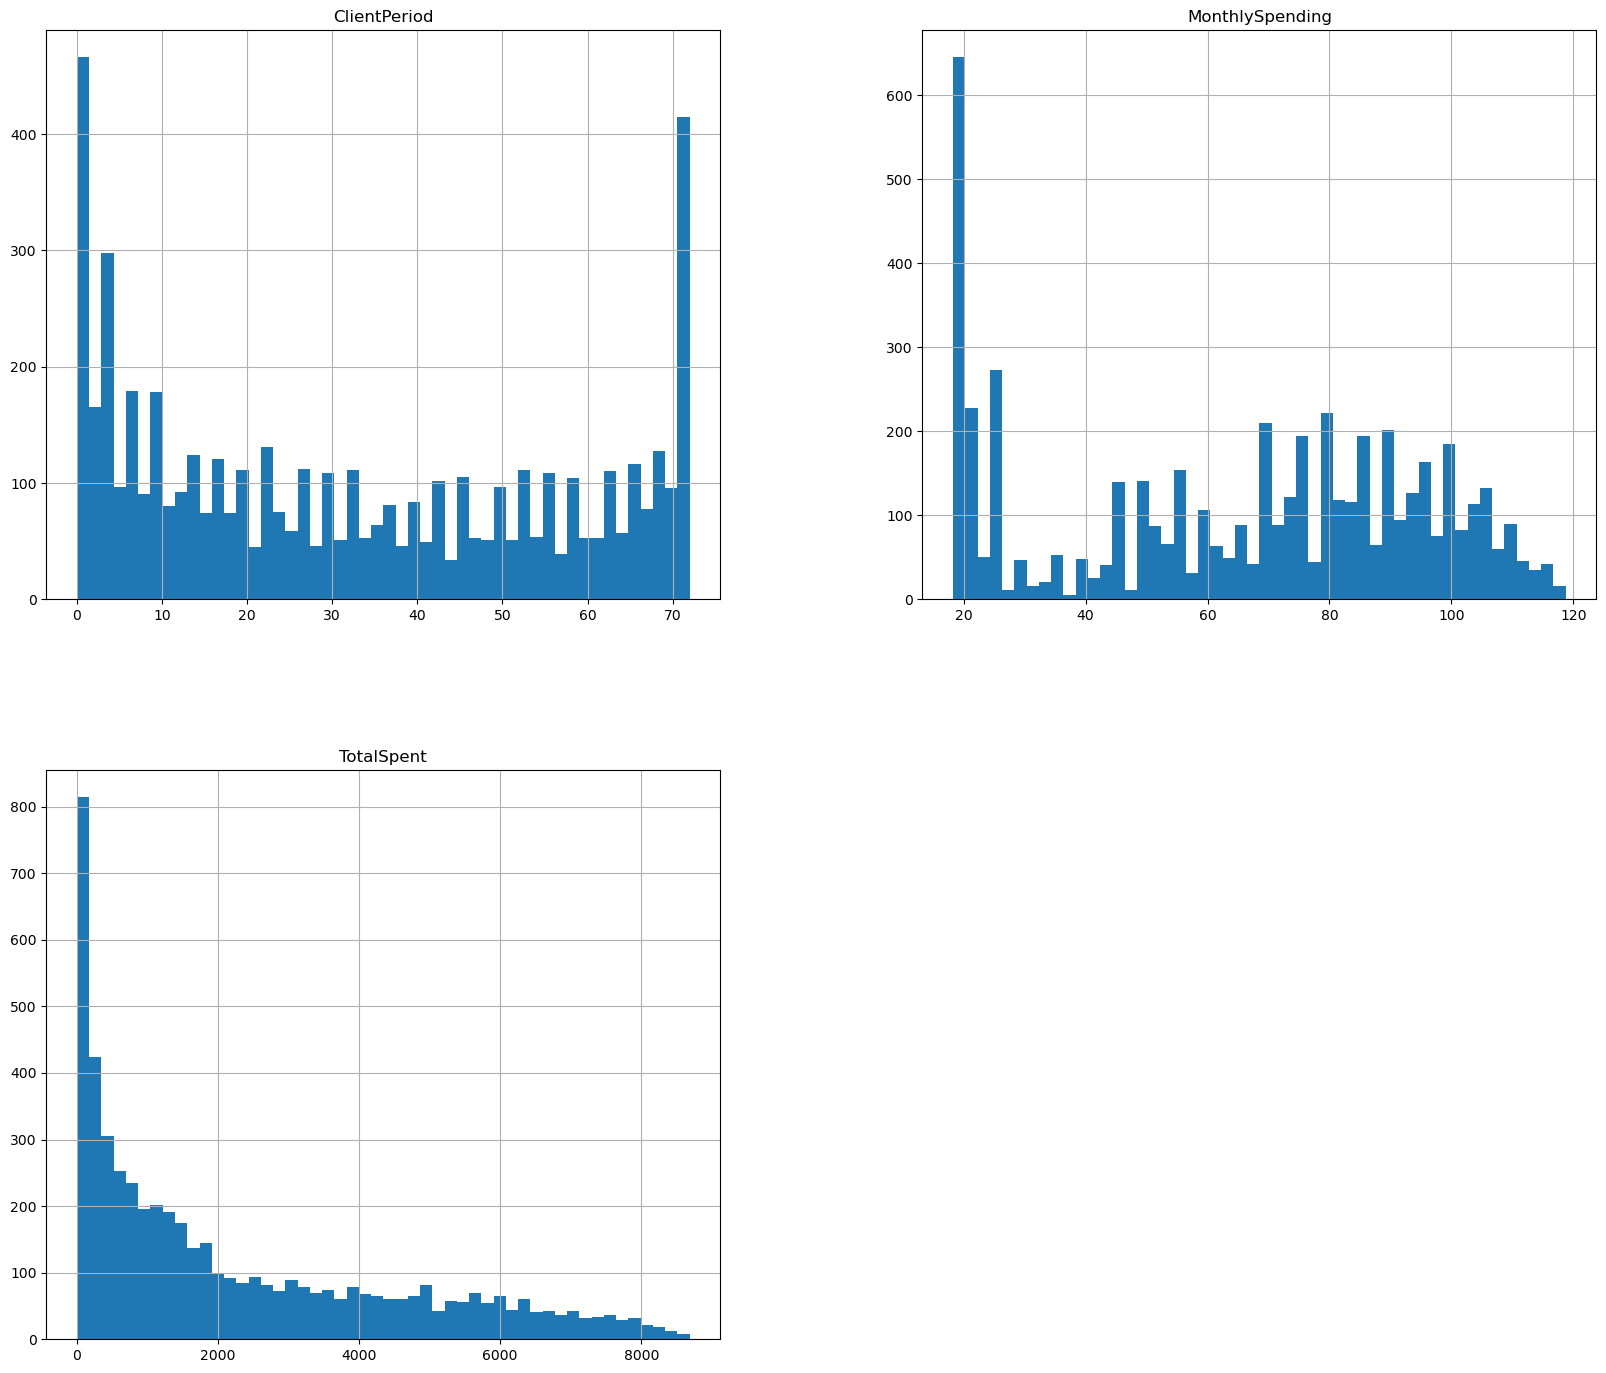

In [9]:
#Для численных призанков построим гистограмму (plt.hist(...))
data[num_cols].hist(bins = 50, figsize = (20, 17))
None

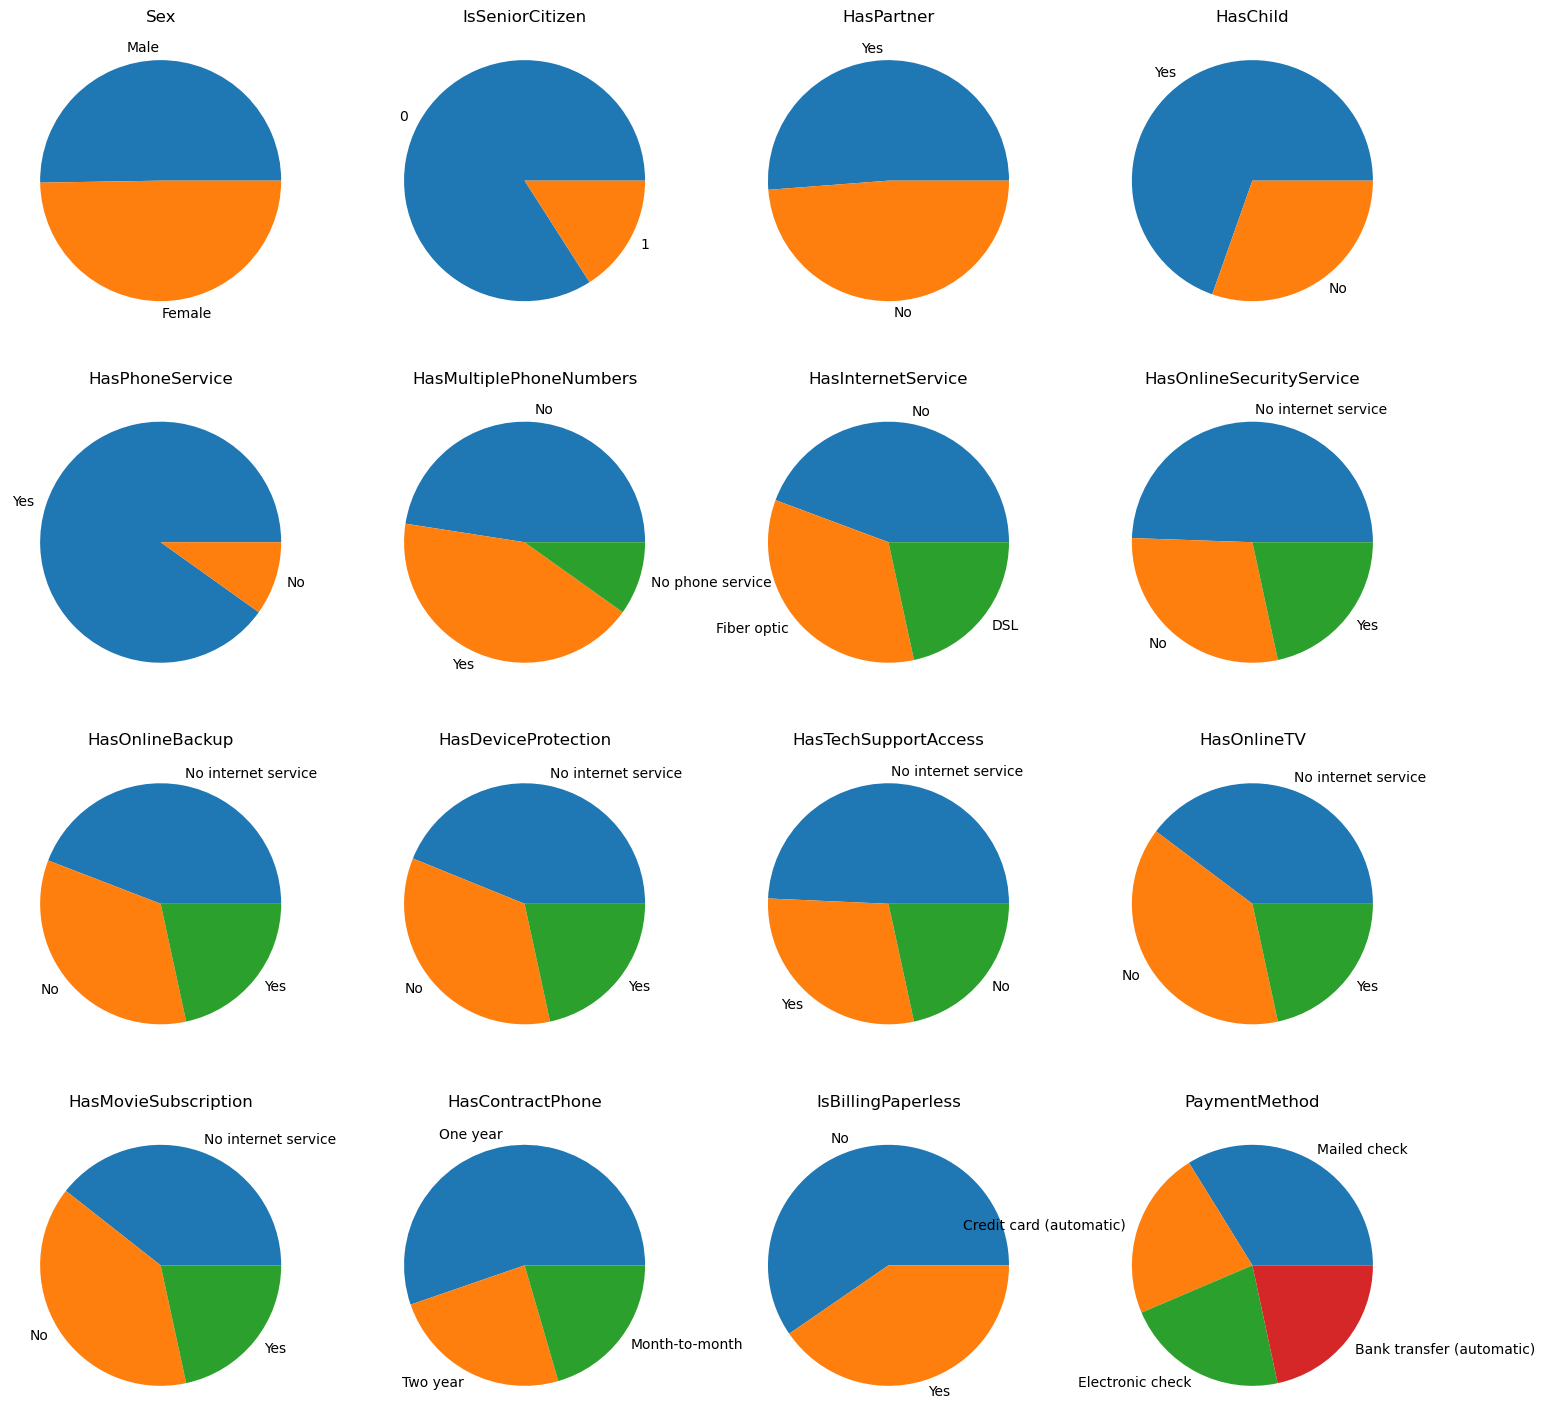

In [10]:
#Для категориальных посчитаем количество каждого значения для каждого признака. 
fig, axes = plt.subplots(4, 4, figsize=(18, 18))

for i in range(4):
    for j in range(4):
        axes[i, j].set_title(f'{cat_cols[4 * i + j]}')
        axes[i, j].pie(data[cat_cols[4 * i + j]].value_counts(), labels=data[cat_cols[4 * i + j]].unique())

In [11]:
#Посмотрим на распределение целевой переменной.
data['Churn'].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

Данные несбалансированы, но не сильно

**Посмотрим на корреляцию между признаками:**

In [12]:
data.corr()

,ClientPeriod,MonthlySpending,TotalSpent,Churn
ClientPeriod,1.000000,0.249414,0.826658,-0.350640
MonthlySpending,0.249414,1.000000,0.652014,0.184769
TotalSpent,0.826658,0.652014,1.000000,-0.200033
Churn,-0.350640,0.184769,-0.200033,1.000000


## Применение линейных моделей

1) Обработаем данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируем числовые признаки, а категориальные закодируем с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируем разные значения гиперпараметра C и выберем лучший (С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

In [13]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline

In [14]:
#обработаем данные
num_data=data[num_cols]
cat_data=data[cat_cols]

In [15]:
#one-code encoding
dummy_features = pd.get_dummies(cat_data)

In [16]:
dummy_features.head()

,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,1,1,0,0,1,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
2,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3,1,0,0,1,0,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
4,1,0,1,0,0,1,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0


In [17]:
X = pd.concat([num_data, dummy_features], axis = 1)
X.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,1,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,1,1,0,0,1,1,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,0,0,1,0,1,1,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,1,0,1,0,0,1,0,...,1,0,0,1,1,0,0,1,0,0


In [18]:
y = data['Churn']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size = 0.8, random_state=42)

In [20]:
#нормировка
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

In [21]:
logmod = LogisticRegressionCV(Cs=[100., 10., 1., 0.1, 0.01, 0.001], cv=5, scoring='roc_auc', refit=True)
logmod.fit(X_train_sc, y_train)

LogisticRegressionCV(Cs=[100.0, 10.0, 1.0, 0.1, 0.01, 0.001], cv=5,
                     scoring='roc_auc')

In [22]:
y_pred = logmod.predict_proba(X_test_sc)[:, 1]

In [23]:
logmod.C_

array([100.])

In [24]:
roc_auc_score(y_test, y_pred)

0.8268163389699026

Выпишем, какое лучшее качество удалось получить

0.8268

## Применение градиентного бустинга

Будем использовать catboost, поэтому нам не надо кодировать категориальные признаки.

1) Разделим выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

In [187]:
#градиентный бустинг с использованием catboost
import catboost

In [25]:
X_origin = data.iloc[:, :-1]
X_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   object 
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [188]:
#Разделим выборку на train/valid.

X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, random_state=42)

In [27]:
boostmodst = catboost.CatBoostClassifier(cat_features=np.arange(3, 19))    #cat_cols)
boostmodst.fit(X_train_origin, y_train)
y_pred1 = boostmodst.predict_proba(X_test_origin)[:, 1]
roc_auc_score(y_test, y_pred1)

Learning rate set to 0.019062
0:	learn: 0.6798227	total: 191ms	remaining: 3m 10s
1:	learn: 0.6678084	total: 212ms	remaining: 1m 45s
2:	learn: 0.6553003	total: 237ms	remaining: 1m 18s
3:	learn: 0.6435910	total: 259ms	remaining: 1m 4s
4:	learn: 0.6326850	total: 283ms	remaining: 56.3s
5:	learn: 0.6225823	total: 306ms	remaining: 50.7s
6:	learn: 0.6128742	total: 326ms	remaining: 46.3s
7:	learn: 0.6048572	total: 337ms	remaining: 41.8s
8:	learn: 0.5958847	total: 358ms	remaining: 39.4s
9:	learn: 0.5871696	total: 379ms	remaining: 37.5s
10:	learn: 0.5792007	total: 404ms	remaining: 36.3s
11:	learn: 0.5713099	total: 427ms	remaining: 35.1s
12:	learn: 0.5643834	total: 447ms	remaining: 33.9s
13:	learn: 0.5569418	total: 468ms	remaining: 33s
14:	learn: 0.5502712	total: 490ms	remaining: 32.1s
15:	learn: 0.5441586	total: 512ms	remaining: 31.5s
16:	learn: 0.5381109	total: 535ms	remaining: 30.9s
17:	learn: 0.5324322	total: 558ms	remaining: 30.5s
18:	learn: 0.5268003	total: 586ms	remaining: 30.2s
19:	learn:

169:	learn: 0.3882153	total: 4.21s	remaining: 20.6s
170:	learn: 0.3879833	total: 4.24s	remaining: 20.5s
171:	learn: 0.3878007	total: 4.26s	remaining: 20.5s
172:	learn: 0.3878002	total: 4.27s	remaining: 20.4s
173:	learn: 0.3876802	total: 4.3s	remaining: 20.4s
174:	learn: 0.3876706	total: 4.32s	remaining: 20.4s
175:	learn: 0.3874036	total: 4.34s	remaining: 20.3s
176:	learn: 0.3873755	total: 4.36s	remaining: 20.3s
177:	learn: 0.3873591	total: 4.38s	remaining: 20.2s
178:	learn: 0.3873043	total: 4.4s	remaining: 20.2s
179:	learn: 0.3871391	total: 4.43s	remaining: 20.2s
180:	learn: 0.3869335	total: 4.49s	remaining: 20.3s
181:	learn: 0.3866917	total: 4.52s	remaining: 20.3s
182:	learn: 0.3864635	total: 4.54s	remaining: 20.3s
183:	learn: 0.3862606	total: 4.59s	remaining: 20.4s
184:	learn: 0.3862287	total: 4.6s	remaining: 20.3s
185:	learn: 0.3861306	total: 4.63s	remaining: 20.3s
186:	learn: 0.3858783	total: 4.65s	remaining: 20.2s
187:	learn: 0.3858598	total: 4.67s	remaining: 20.2s
188:	learn: 0.3

331:	learn: 0.3732342	total: 7.72s	remaining: 15.5s
332:	learn: 0.3730373	total: 7.75s	remaining: 15.5s
333:	learn: 0.3730239	total: 7.78s	remaining: 15.5s
334:	learn: 0.3728094	total: 7.8s	remaining: 15.5s
335:	learn: 0.3727191	total: 7.83s	remaining: 15.5s
336:	learn: 0.3725564	total: 7.85s	remaining: 15.5s
337:	learn: 0.3725012	total: 7.89s	remaining: 15.4s
338:	learn: 0.3723967	total: 7.91s	remaining: 15.4s
339:	learn: 0.3723952	total: 7.92s	remaining: 15.4s
340:	learn: 0.3723505	total: 7.97s	remaining: 15.4s
341:	learn: 0.3721993	total: 8s	remaining: 15.4s
342:	learn: 0.3721464	total: 8.02s	remaining: 15.4s
343:	learn: 0.3720769	total: 8.04s	remaining: 15.3s
344:	learn: 0.3720496	total: 8.07s	remaining: 15.3s
345:	learn: 0.3719755	total: 8.1s	remaining: 15.3s
346:	learn: 0.3719437	total: 8.12s	remaining: 15.3s
347:	learn: 0.3718225	total: 8.15s	remaining: 15.3s
348:	learn: 0.3718059	total: 8.19s	remaining: 15.3s
349:	learn: 0.3717976	total: 8.21s	remaining: 15.3s
350:	learn: 0.371

495:	learn: 0.3571448	total: 11.4s	remaining: 11.6s
496:	learn: 0.3570744	total: 11.4s	remaining: 11.6s
497:	learn: 0.3569443	total: 11.5s	remaining: 11.5s
498:	learn: 0.3569074	total: 11.5s	remaining: 11.5s
499:	learn: 0.3568648	total: 11.5s	remaining: 11.5s
500:	learn: 0.3568328	total: 11.5s	remaining: 11.5s
501:	learn: 0.3566875	total: 11.5s	remaining: 11.4s
502:	learn: 0.3565992	total: 11.6s	remaining: 11.4s
503:	learn: 0.3565116	total: 11.6s	remaining: 11.4s
504:	learn: 0.3563565	total: 11.6s	remaining: 11.4s
505:	learn: 0.3563492	total: 11.6s	remaining: 11.4s
506:	learn: 0.3562508	total: 11.7s	remaining: 11.3s
507:	learn: 0.3561802	total: 11.7s	remaining: 11.3s
508:	learn: 0.3561754	total: 11.7s	remaining: 11.3s
509:	learn: 0.3560655	total: 11.7s	remaining: 11.3s
510:	learn: 0.3560227	total: 11.7s	remaining: 11.2s
511:	learn: 0.3558538	total: 11.8s	remaining: 11.2s
512:	learn: 0.3556728	total: 11.8s	remaining: 11.2s
513:	learn: 0.3555847	total: 11.8s	remaining: 11.2s
514:	learn: 

658:	learn: 0.3404160	total: 15.6s	remaining: 8.08s
659:	learn: 0.3402538	total: 15.6s	remaining: 8.05s
660:	learn: 0.3401736	total: 15.7s	remaining: 8.03s
661:	learn: 0.3400461	total: 15.7s	remaining: 8.01s
662:	learn: 0.3399206	total: 15.7s	remaining: 7.98s
663:	learn: 0.3398097	total: 15.7s	remaining: 7.96s
664:	learn: 0.3398096	total: 15.7s	remaining: 7.93s
665:	learn: 0.3396917	total: 15.8s	remaining: 7.9s
666:	learn: 0.3396861	total: 15.8s	remaining: 7.88s
667:	learn: 0.3395033	total: 15.8s	remaining: 7.85s
668:	learn: 0.3394443	total: 15.8s	remaining: 7.83s
669:	learn: 0.3393422	total: 15.8s	remaining: 7.8s
670:	learn: 0.3391934	total: 15.9s	remaining: 7.78s
671:	learn: 0.3390958	total: 15.9s	remaining: 7.76s
672:	learn: 0.3390083	total: 15.9s	remaining: 7.73s
673:	learn: 0.3389149	total: 15.9s	remaining: 7.71s
674:	learn: 0.3389071	total: 16s	remaining: 7.69s
675:	learn: 0.3388379	total: 16s	remaining: 7.66s
676:	learn: 0.3386786	total: 16s	remaining: 7.64s
677:	learn: 0.338604

821:	learn: 0.3272288	total: 19.8s	remaining: 4.29s
822:	learn: 0.3271414	total: 19.8s	remaining: 4.27s
823:	learn: 0.3270555	total: 19.9s	remaining: 4.24s
824:	learn: 0.3269344	total: 19.9s	remaining: 4.22s
825:	learn: 0.3267888	total: 19.9s	remaining: 4.2s
826:	learn: 0.3267566	total: 19.9s	remaining: 4.17s
827:	learn: 0.3267245	total: 20s	remaining: 4.15s
828:	learn: 0.3264680	total: 20s	remaining: 4.12s
829:	learn: 0.3263352	total: 20s	remaining: 4.1s
830:	learn: 0.3262118	total: 20s	remaining: 4.08s
831:	learn: 0.3261863	total: 20.1s	remaining: 4.05s
832:	learn: 0.3261414	total: 20.1s	remaining: 4.03s
833:	learn: 0.3260814	total: 20.1s	remaining: 4s
834:	learn: 0.3260337	total: 20.2s	remaining: 3.98s
835:	learn: 0.3259300	total: 20.2s	remaining: 3.96s
836:	learn: 0.3258507	total: 20.2s	remaining: 3.94s
837:	learn: 0.3257711	total: 20.2s	remaining: 3.91s
838:	learn: 0.3257329	total: 20.3s	remaining: 3.89s
839:	learn: 0.3256526	total: 20.3s	remaining: 3.86s
840:	learn: 0.3255744	tot

981:	learn: 0.3144237	total: 23.7s	remaining: 435ms
982:	learn: 0.3143525	total: 23.8s	remaining: 411ms
983:	learn: 0.3142396	total: 23.8s	remaining: 387ms
984:	learn: 0.3141644	total: 23.8s	remaining: 363ms
985:	learn: 0.3140697	total: 23.8s	remaining: 338ms
986:	learn: 0.3139880	total: 23.9s	remaining: 314ms
987:	learn: 0.3139037	total: 23.9s	remaining: 290ms
988:	learn: 0.3138241	total: 23.9s	remaining: 266ms
989:	learn: 0.3137395	total: 23.9s	remaining: 242ms
990:	learn: 0.3137221	total: 24s	remaining: 218ms
991:	learn: 0.3136837	total: 24s	remaining: 193ms
992:	learn: 0.3135971	total: 24s	remaining: 169ms
993:	learn: 0.3134480	total: 24s	remaining: 145ms
994:	learn: 0.3132608	total: 24.1s	remaining: 121ms
995:	learn: 0.3131919	total: 24.1s	remaining: 96.7ms
996:	learn: 0.3131860	total: 24.1s	remaining: 72.5ms
997:	learn: 0.3130678	total: 24.1s	remaining: 48.4ms
998:	learn: 0.3130572	total: 24.2s	remaining: 24.2ms
999:	learn: 0.3129858	total: 24.2s	remaining: 0us


0.823387759625419

In [28]:
boostmod = catboost.CatBoostClassifier(silent=True,
                                             cat_features=np.arange(3, 19),
                                             eval_metric='AUC')
grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [1, 2, 4],
        'l2_leaf_reg': [2, 4, 8],
        'iterations': [200, 400, 800]}

boostmod.grid_search(grid, 
                           X_train_origin, 
                           y_train, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8301630435
bestIteration = 197

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8301630	best: 0.8301630 (0)	total: 1.27s	remaining: 1m 41s

bestTest = 0.8404503106
bestIteration = 166

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8404503	best: 0.8404503 (1)	total: 2.43s	remaining: 1m 36s

bestTest = 0.8433042903
bestIteration = 155

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8433043	best: 0.8433043 (2)	total: 3.58s	remaining: 1m 33s

bestTest = 0.8316583276
bestIteration = 196

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8316583	best: 0.8433043 (2)	total: 4.82s	remaining: 1m 32s



bestTest = 0.83715781
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
33:	loss: 0.8371578	best: 0.8436817 (32)	total: 1m 25s	remaining: 1m 57s

bestTest = 0.8404862549
bestIteration = 196

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
34:	loss: 0.8404863	best: 0.8436817 (32)	total: 1m 26s	remaining: 1m 54s

bestTest = 0.8445910973
bestIteration = 178

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
35:	loss: 0.8445911	best: 0.8445911 (35)	total: 1m 28s	remaining: 1m 50s

bestTest = 0.8399399011
bestIteration = 397

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
36:	loss: 0.8399399	best: 0.8445911 (35)	total: 1m 32s	remainin


bestTest = 0.840187917
bestIteration = 386

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
66:	loss: 0.8401879	best: 0.8445911 (35)	total: 4m 8s	remaining: 51.8s

bestTest = 0.8427938808
bestIteration = 231

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
67:	loss: 0.8427939	best: 0.8445911 (35)	total: 4m 14s	remaining: 48.7s

bestTest = 0.8371362434
bestIteration = 64

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
68:	loss: 0.8371362	best: 0.8445911 (35)	total: 4m 21s	remaining: 45.5s

bestTest = 0.8411368473
bestIteration = 352

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
69:	loss: 0.8411368	best: 0.8445911 (35)	total: 4m 28s	remaining: 4

{'params': {'depth': 2,
  'l2_leaf_reg': 8,
  'iterations': 200,
  'learning_rate': 0.3},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [29]:
y_pred2 = boostmod.predict_proba(X_test_origin)[:, 1]
print(roc_auc_score(y_test, y_pred2))

0.8252948347355491


# Логистическая с GridSearchCV

In [25]:
#разделяем на train/test
X_train1, X_test1, y_train1, y_test1 = train_test_split(data[feature_cols], data[target_col], test_size=0.2, random_state=42)

In [26]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(
    [('num', make_pipeline(StandardScaler(), MinMaxScaler()), num_cols),
    ('col', OneHotEncoder(), cat_cols)]
)

pipeline1 = make_pipeline(ct, LogisticRegression(max_iter = 1000))

In [27]:
#подбираем наилучшие гиперпараметры
gs = GridSearchCV(pipeline1, param_grid = {"logisticregression__C": [64.8, 64.9, 65, 65.1, 65.2]}, scoring = 'roc_auc', refit = True)

In [28]:
gs.fit(X_train1, y_train1)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('col',
                                                                         O

In [29]:
pred=gs.predict_proba(X_test1)[:, 1]
roc_auc_score(y_test1, pred)

0.8273658351880755

Лучшее качество и соответствующий параметр:

In [30]:
gs.best_score_, gs.best_params_

(0.8487855344431683, {'logisticregression__C': 64.9})

# Предсказания

In [31]:
X_test_fin = pd.read_csv('./test.csv')
X_test_fin['TotalSpent'] = pd.to_numeric(X_test_fin['TotalSpent'], errors='coerce').fillna(0)
X_test_fin.loc[:, 'IsSeniorCitizen'] = X_test_fin.IsSeniorCitizen.astype('str')

final_pred = gs.best_estimator_.predict_proba(X_test_fin)[:, 1]

submission = pd.read_csv('./submission.csv')
submission['Churn'] = final_pred 
submission.to_csv('./my_submission.csv', index=False)

In [32]:
X_test_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   object 
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [34]:
#посмотрим на итоговые данные
submission.head()

,Id,Churn
0,0,0.038420
1,1,0.747366
2,2,0.683059
3,3,0.005851
4,4,0.001095
